# Distributed optimization algorithms
The goal of this notebook is to work on distributed optimization algorithms, which are the foundation for large scale analytics and machine learning. Specifically, we will focus on the details of stochastic gradient descent (SGD). To do so, we will work on a simple regression problem, where we will apply SGD to minimize a loss function, as defined for the problem at hand. The emphasis of this laboratory is **not** on the machine learning part: even if you've never worked on regression problems, this shouldn't prevent you from being successful in developing the Notebook.

Next, an outline of the steps we will follow in this Notebook:

* Breif introduction to linear regression
* Implementation of serial algorithms: from Gradient Descent, to Stochastic Gradient Descent
* Implementation of distributed algorithms with Apache Spark


### Initialization code

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats 

from sklearn.datasets.samples_generator import make_regression

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


## A simple example: linear regression
Let’s see briefly how to use gradient descent in a simple least squares regression setting. Asssume we have an output variable $y$ which we think depends linearly on the input vector $x$. That is, we have:

$$x = \begin{bmatrix}x_1 \\ x_2 \\ \cdots \\ x_m\end{bmatrix}, y = \begin{bmatrix}y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix}$$

We approximate $y_i$ by:

$$ f_{\theta}(x_i) = \theta_1 + \theta_2 x_i$$

Define the loss function for the simple linear least squares regression as follows:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

Now, let's use scikit learn to create a regression problem. A few notes are in order:

* The call to ```make_regression``` essentially generates samples for a regression problem
* The call to ```stats.linegress``` calculates a linear least-squares regression for two sets of measurements

This means we have a sort of "basline" to experiment with our SGD implementation.

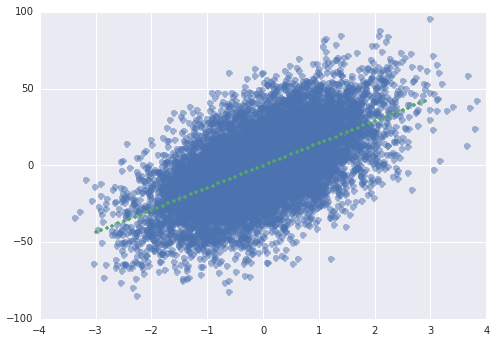

In [2]:
x, y = make_regression(n_samples = 10000, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
x = x.flatten()
slope, intercept,_,_,_ = stats.linregress(x,y)
best_fit = np.vectorize(lambda x: x * slope + intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

## Batch gradient descent
Before delving into SGD, let's take a simpler approach. Assume that we have a vector of paramters $\theta$ and a loss function $J(\theta)$, which we want to minimize. The loss function we defined above has the form:

$$ J(\theta) = \sum_{i=1}^{m} J_i(\theta)$$

where $J_i$ is associated with the i-th observation in our data set, such as the one we generated above. The batch gradient descent algorithm, starts with some initial feasible parameter $\theta$ (which we can either fix or assign randomly) and then repeatedly performs the update:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J(\theta^{(t)}) = \theta^{(t)} - \eta \sum_{i=1}^{m} \nabla_{\theta} J_i(\theta^{(t)}) $$

where $t$ is an iteration index, and $\eta$ is a constant controlling step-size and is called the learning rate. Note that in order to make a **single update**, we need to calculate the gradient **using the entire dataset**. This can be very inefficient for large datasets, and it is the goal of this Notebook to insist on this aspect.

In code, the main loop for batch gradient descent looks like this:

```python
for i in range(n_epochs):
  params_grad = evaluate_gradient(loss_function, data, params)
  params = params - learning_rate * params_grad
```

For a given number of iterations (also called epochs) $n_{e}$ , we first evaluate the gradient vector of the loss function using **ALL** examples in the data set, and then we update the parameters with a given learning rate. Batch gradient descent is guaranteed to converge to the global minimum for convex loss surfaces and to a local minimum for non-convex surfaces.

<div class="alert alert-warning">
<b>NOTE:</b> Who computes the gradient?
<br>
<br>
Given a loss function $J(\theta)$, the gradient with respect to paramters $\theta$ must be derived manually. In other words, given the expression of $J(\theta)$, pencil and paper are required to derive the analytical form of its gradient. Then this expression can be plugged into our code.

Recently, machine learning libraries have adopted the techniques of **automatic differentiation**, which eliminate this tedious and error prone step. Given a loss function $J(\theta)$, such libraries automatically compute the gradient.
</div>


For the linear regression case, let's derive the update step for gradient descent. Recall that we have defined:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

$$f_\theta(x_i) = \theta_1 + \theta_2 x_i$$

So we have that:

$$ \nabla_\theta J(\theta) = \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (\theta_1 + \theta_2 x_i - y_i)^2 $$

If we explicit the partial derivatives of the gradient, we have:

$$\frac{\partial J(\theta)}{\partial \theta_1} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i)$$
$$\frac{\partial J(\theta)}{\partial \theta_2} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i) x_i$$

So now we can explicit the update rules for the two model parameters:

$$ \theta_1^{(t+1)} = \theta_1^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i)$$

$$ \theta_2^{(t+1)} = \theta_2^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i) x_i$$


### Using matrix notation
Now, before writing some code, let's see how can we simplify the above expressions using matrices. Note that this is not only useful for working on a more compact notation, but it helps reason about efficient computations using libraries such as numpy, which we will use extensively.

We firstly expressed our prediction as: $f_\theta (x_i) = \theta_1 + \theta_2 x_i$. Let's introduce a surrogate dimension for our input set $x$, such that:

$$x = 
\begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix}
$$

where we define, with a small abuse of notation, $x_i = \begin{bmatrix} 1 & x_{i}\end{bmatrix}$. Also, let's define vector $\theta = \begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix}$. 

Then, we can rewrite $f_\theta(x_i) = x_i \theta = \begin{bmatrix} 1 & x_{i}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} = \theta_1 + \theta_2 x_i$.

Let's use this notation to rewrite our gradients in matrix form.


$\nabla_\theta J(\theta) =  \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{m} (x_i \theta - y_i) x_i^T =$


$= x^T (x \theta - y) =$


$= \begin{bmatrix} 1 & 1 & \cdots & 1 \\ x_1 & x_2 & \cdots & x_m \end{bmatrix} 
\Bigg( \begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} - 
\begin{bmatrix} y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix} \Bigg)$

### Numpy arrays
With the work we did above, we can now cast everything into numpy arrays, which are efficient, and for which an efficient implementation of vector and matrix operations exists. Specifically, above we used the traditional matrix notation, where we manipulate column vectors. Hence, we express matrix operations (namely matrix products) using the traditional "row-by-column" approach.

In numpy, we avoid this formalism by using dot product operations. So, given two column vectors:
$$a= \begin{bmatrix} a_1 \\ a_2 \\ \cdots \\ a_{m}\end{bmatrix} b= \begin{bmatrix} b_1 \\ b_2 \\ \cdots \\ b_{m}\end{bmatrix}$$
we have that $a b^T = a \cdot b = a_1 b_1 + a_2 b_2 + \cdots + a_m b_m$, where $\cdot$ is the symbol we use for dot product.


<div class="alert alert-block alert-info">
<strong>Question 1.</strong> Implement your own version of Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>

The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>




Scikitlearn values:
Intercept:  -0.106823564161
Slope:  14.5151694796

Gradient descent values:
Intercept:  -0.0971624928155
Slope:  14.4913630045


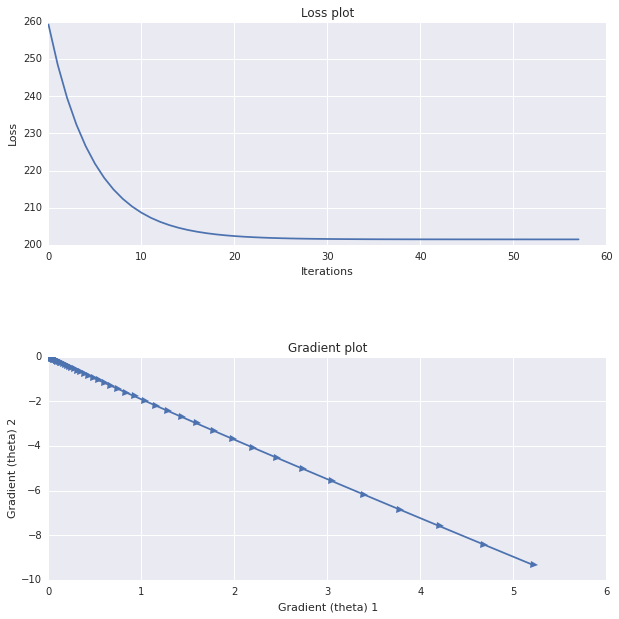

In [6]:
####### GRADIENT DESCENT #########
#one main loop in which we iterate improving the current solution
#at each iteration the whole dataset is used to make the update
def gradient_descent(x, y, theta1, theta2, learning_rate, max_iter, marg_improv):
    #theta array
    theta = np.array([theta1,theta2])
    #x matrix with 1s
    x_ones = np.array([np.ones(x.size),x])
    
    #history vectors
    loss_values=[]
    gradients=[]
    thetas=[]
    
    import sys
    prev_j = sys.maxsize
    
    #loop at most max_iter times; at each iteration, the updates are done considering the entire datasets
    for i in range(max_iter):
        #compute loss (j) and gradient (g)
        x_theta = x_ones.T.dot(theta)
        j = 0.5 * (x_theta - y).dot((x_theta - y).T) / x.size
        g = x_ones.dot(x_theta - y) / x.size
        #update the thetas
        theta = theta - learning_rate*g
        
        #save history
        thetas.append(theta)
        loss_values.append(j)
        gradients.append(g)
        
        #if the loss is less then marginal improvement we're done
        if(abs(j-prev_j) < marg_improv):
            break
        #save the previous value of the loss
        prev_j = j
    return theta, np.array(thetas), np.array(loss_values), np.array(gradients)


####################################
####################################

gd_theta, gd_thetas, gd_loss_values, gd_gradients = gradient_descent(x,y,5,5,0.1,100,0.0001)

print("Scikitlearn values:")
print("Intercept: ", intercept)
print("Slope: ", slope)
print("\nGradient descent values:")
print("Intercept: ", gd_theta[0])
print("Slope: ", gd_theta[1])


fig, arr = plt.subplots(2)
fig.subplots_adjust(hspace=.5)
fig.set_size_inches(10, 10)

arr[0].plot(np.arange(len(gd_loss_values)), gd_loss_values)
arr[0].set_xlabel("Iterations")
arr[0].set_ylabel("Loss")
arr[0].set_title("Loss plot")
arr[1].plot(gd_gradients[:,0], gd_gradients[:,1], '->')
arr[1].set_xlabel("Gradient (theta) 1")
arr[1].set_ylabel("Gradient (theta) 2")
arr[1].set_title("Gradient plot")
plt.show()

The batch gradient descent compute the gradient using the whole dataset at each iteration; this means that it makes small steps towards the optimal solution. The "step size" depends on the learning rate. As we can see from the first image, the loss function slowly and smoothly decrease as the number of iterations increase, to finally stopping (at ~60) because of the marginal improvement condition.

<div class="alert alert-block alert-info">
<strong>Question 2.</strong> Plot the regression line, along with the training data, given the coefficients $\theta$ that you have obtained with Gradient Descent.
</div>

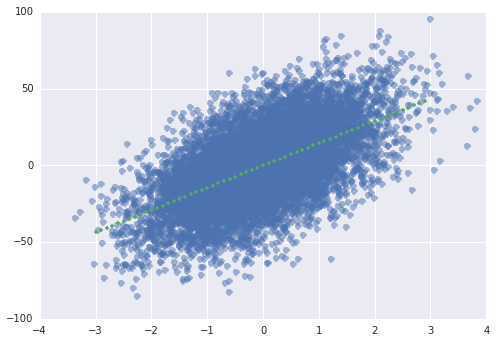

In [4]:
#f(x) function
fx = (np.array([np.ones(x.size),x])).T.dot(gd_theta)

#the f(x) values are used in the linregress
slope, intercept,_,_,_ = stats.linregress(x, fx)
best_fit = np.vectorize(lambda x: x * slope + intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

<div class="alert alert-block alert-info">
<strong>Question 3.</strong> Plot a 3D surface representing: on the x,y axes the parameter values, on the z axis the loss value. Additionally, plot the trajectory of the loss function on the 3D surface, using the history you collected in the gradient_descent function you designed.

Finally, plot a contour projection of the 3D surface, along with the corresponding projection of the trajectory followed by your Gradient Descent algorithm.
</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


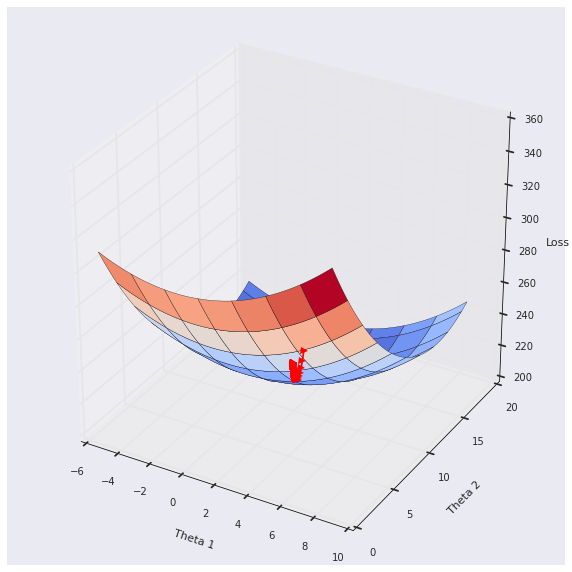

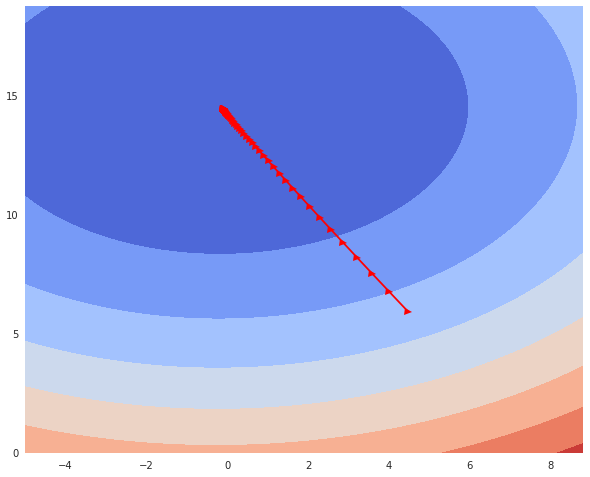

In [5]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig.set_size_inches(10, 10)

## 3D SURFACE ##
ax = fig.gca(projection='3d')

p1_min = int(np.amin(gd_thetas[:,0]))
p1_max = int(np.amax(gd_thetas[:,0]))
p2_min = int(np.amin(gd_thetas[:,1]))
p2_max = int(np.amax(gd_thetas[:,1]))

p1 = np.arange(p1_min-5, p1_max+5, 0.2)
p2 = np.arange(p2_min-5, p2_max+5, 0.2)
Z = np.ones((len(p2), len(p1)))
p1,p2 = np.meshgrid(p1,p2)

for i in range(0, p1.shape[0]):
    for j in range(0, p1.shape[1]):
        loss = 0
        for k in range(0, len(x)):
            loss += (p1[i][j] + p2[i][j]*x[k] - y[k])**2
        loss /= (2*len(x))
        Z[i,j] = loss
        
ax.plot_surface(p1, p2, Z, cmap=cm.coolwarm)
ax.set_xlabel("Theta 1")
ax.set_ylabel("Theta 2")
ax.set_zlabel("Loss")

## TRAJECTORY ##
plt.plot(gd_thetas[:, 0], gd_thetas[:, 1], gd_loss_values, "r->")
plt.show()

## CONTOURF ##
fig = plt.figure()
fig.set_size_inches(10, 8)
plt.contourf(p1, p2, Z, cmap=cm.coolwarm)
plt.plot(gd_thetas[:, 0], gd_thetas[:, 1], "r->")
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 4.</strong> Plot the path the gradient takes from its initial to its final position.

This is a two dimensional plot (because our parameter vector has size 2), with a point for each gradient value, and a line connecting the points.
</div>

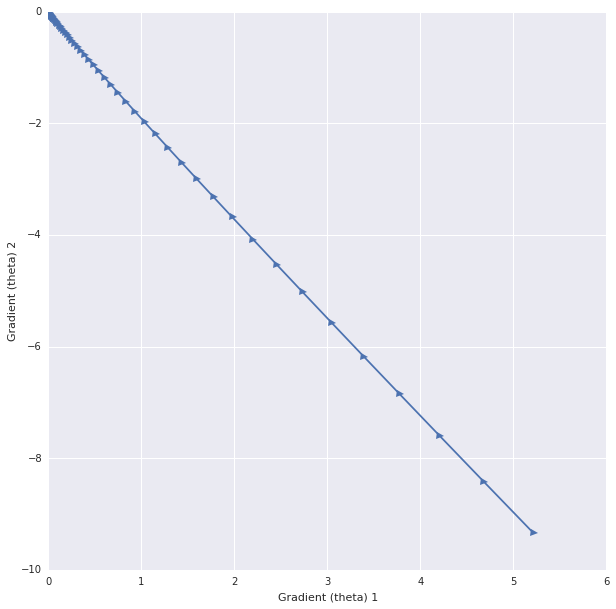

In [6]:
fig = plt.figure()

fig.set_size_inches(10, 10)

#plt.scatter(gd_gradients[:,0], gd_gradients[:,1], zorder=2)
plt.plot(gd_gradients[:,0], gd_gradients[:,1], '->')
plt.xlabel("Gradient (theta) 1")
plt.ylabel("Gradient (theta) 2")
plt.show()

## Stochastic Gradient Descent

The gradient descent algorithm makes intuitive sense as it always proceeds in the direction of steepest descent (the gradient of $J$) and guarantees that we find a local minimum (global under certain assumptions on $J$). When we have very large data sets, however, computing $\nabla_\theta J(\theta)$ can be computationally challenging: as noted above, we must process every data point before making a single step (hence the name "batch"). 

An alternative approach to alleviate such computational costs is the Stochastic Gradient Descent method: essentially, the idea is to update the parameters $\theta$ sequentially (one data point at the time), with every observation $x_i, y_i$. Following the same notation we used for Gradient Descent, the following expression defines how to update parameters, while processing one data point at the time:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J_i(\theta^{(t)}) $$


The stochastic gradient approach allows us to start making progress on the minimization problem one step at the time. It is computationally cheaper, but it results in a larger variance of the loss function in comparison with batch gradient descent.

Generally, the stochastic gradient descent method will get close to the optimal $\theta$ much faster than the batch method, but will never fully converge to the local (or global) minimum. Thus the stochastic gradient descent method is useful when we are satisfied with an **approximation** for the solution to our optimization problem. 

A full recipe for stochastic gradient descent follows:

```python 
for i in range(n_epochs):
  np.random.shuffle(data)
  for example in data:
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
```

The reshuffling of the data is done to avoid a bias in the optimization algorithm by providing the data examples in a particular order.

<div class="alert alert-block alert-info">
<strong>Question 5.</strong> Implement your own version of Stochastic Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>

    
The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

Scikitlearn values:
Intercept:  -0.106823564161
Slope:  14.5151694796

Stochastic gradient descent values:
Intercept:  -0.206913195781
Slope:  14.6316753242


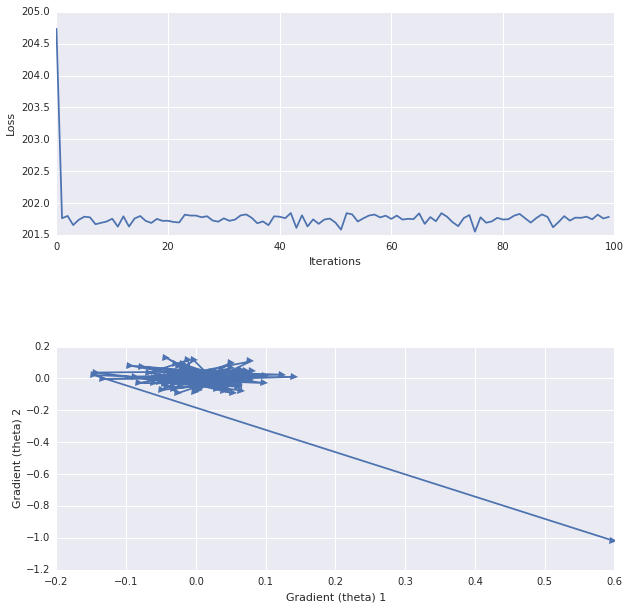

In [27]:
#stochastic gradient descent
#the updates are made sequentially, considering one data point at the time
#the result is a more efficient algorithm respect to the batch version
#but with an higher variance
def stochastic_gradient_descent(x, y, theta1, theta2, learning_rate, max_iter, marg_improv):
    #theta array
    theta = np.array([theta1,theta2])
    
    #history vectors
    loss_values=[]
    gradients=[]
    thetas=[]

    import sys
    bestj = sys.maxsize
    
    for i in range(max_iter):
        xy = np.array(list(zip(x,y)))
        np.random.shuffle(xy)

        #sequencial update of the gradient and loss
        j = 0
        gs=[]
        for sample_x, sample_y in xy:
            j += 0.5*(theta[0] + theta[1]*sample_x - sample_y)**2
            
            #update the gradient values
            g0=theta[0] + theta[1]*sample_x - sample_y
            g1=(theta[0] + theta[1]*sample_x - sample_y)*sample_x
            
            #update the model
            g=np.array([g0, g1])
            gs.append(g)
            theta = theta - learning_rate*g
        
        j /= len(xy)
        loss_values.append(j)
        gs = np.array(gs)
        gradients.append([np.mean(gs[:, 0]), np.mean(gs[:, 1])])
        thetas.append(theta)
        
        #stopping condition
        if(j < bestj):
            if(abs(j-bestj) < marg_improv):
                break
            bestj = j
            
    return theta, np.array(thetas), np.array(loss_values), np.array(gradients)



sgd_theta, sgd_thetas, sgd_loss_values, sgd_gradients = stochastic_gradient_descent(x,y,5,5,0.001, 100, 0.0001)



print("Scikitlearn values:")
print("Intercept: ", intercept)
print("Slope: ", slope)
print("\nStochastic gradient descent values:")
print("Intercept: ", sgd_theta[0])
print("Slope: ", sgd_theta[1])

fig, arr = plt.subplots(2)
fig.subplots_adjust(hspace=.5)
fig.set_size_inches(10, 10)

arr[0].plot(np.arange(sgd_loss_values.size), sgd_loss_values)
arr[0].set_xlabel("Iterations")
arr[0].set_ylabel("Loss")
arr[1].plot(sgd_gradients[:,0], sgd_gradients[:,1], '->')
arr[1].set_xlabel("Gradient (theta) 1")
arr[1].set_ylabel("Gradient (theta) 2")

plt.show()

In the case of the stochastic gradient descent, the gradient is updated for each sample in the dataset (inner for-loop). This means that the algorithm is able to reach the  (global/local) optimal solution "region" within a few iterations (outer loop). This is really noticeable by the images above. With the chosen learning rate we can see how it reaches the final region of solutions within a single iteration! By decreasing the learning rate, we can decrease the "step size" slowing down algorithm. Anyhow, the algoritmh will be always faster then the batch gradient descent (unless a very very low learning rate is chosen) to reach the final region; then it will keep oscillating there without fully converging. In this case the same marginal increment as for the batch gradient descent has been used; the condition is never verified and the max number of iteration is reached.

## Mini-batch Stochastic Gradient Descent

Mini-batch gradient descent is a trade-off between stochastic gradient descent and batch gradient descent.  In mini-batch gradient descent, the cost function (and therefore gradient) is averaged over a small number of samples, which is what we call the mini-batch, and that we denote by $mb$.  This is opposed to the SGD batch size of 1 sample, and the BGD size of all the training samples. 

Let's use the notation we introduced above to rewrite the gradients in matrix form for the mini-batch variant:

$\nabla_\theta J(\theta) =  \frac{1}{2 mb} \sum_{i=1}^{mb} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{mb} (x_i \theta - y_i) x_i^T =$


$= x_{mb}^T (x_{mb} \theta - y_{mb})$


What’s the benefit of doing it this way?  First, it smooths out some of the noise in SGD, but not all of it, thereby still allowing the “kick” out of local minimums of the cost function.  Second, the mini-batch size is still small, thereby keeping the performance benefits of SGD.





<div class="alert alert-block alert-info"> 
<strong>Question 6.</strong> Implement your own version of Mini-batch Stochastic Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to extract mini-batches from the training data.
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>


The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

Scikitlearn values:
Intercept:  -0.106823564161
Slope:  14.5151694796

Mini-batch stochastic gradient descent values:
Intercept:  -0.130081056517
Slope:  14.446345048


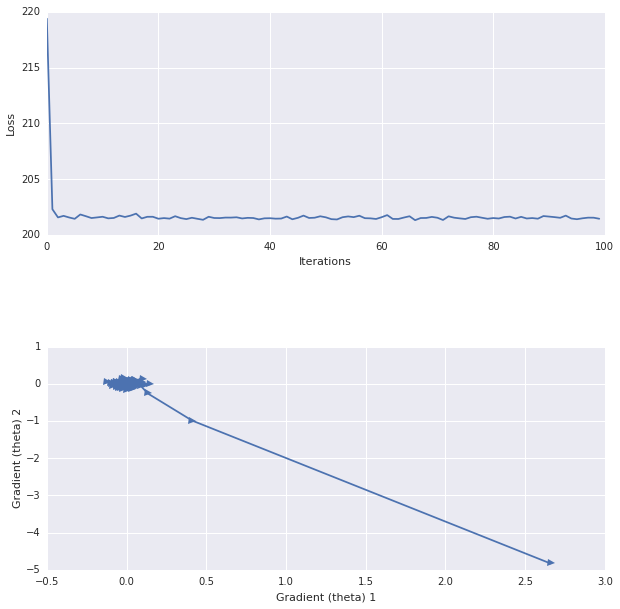

In [26]:
def batch_extractor(data, batch_size):
    batches = []
    for j in range(0, len(data), batch_size):
        if(j+batch_size > len(data)):
            batch_size = len(data) % batch_size
        batches.append(data[j:j+batch_size])
    
    return np.array(batches)

def mini_batch_stochastic_gradient_descent(x, y, theta1, theta2, learning_rate, max_iter, marg_improv):
    #theta array
    theta = np.array([theta1,theta2])
    
    #history vectors
    loss_values=[]
    gradients=[]
    thetas=[]
    
    batch_size = 32
    
    import sys
    bestj = sys.maxsize
    
    xy = np.array(list(zip(x,y)))
    for i in range(max_iter):
        np.random.shuffle(xy)
        batches = batch_extractor(xy, batch_size)

        j=0
        gs=[]
        for i in range(len(batches)):
            X,Y = zip(*batches[i])
            X = np.array(X)
            Y = np.array(Y)
            curr_batch_size = len(X)
            
            #x matrix with one + mini-batch slice
            x_ones = np.array([np.ones(curr_batch_size), X])
            
            #calculate the loss (j) and gradient (g)
            x_theta = x_ones.T.dot(theta)
            j += 0.5 * (x_theta - Y).dot((x_theta - Y).T) / curr_batch_size
            g = x_ones.dot(x_theta - Y) / curr_batch_size
            gs.append(g)
            
            theta = theta - learning_rate*g

        j /= len(batches)
        loss_values.append(j)
        gs = np.array(gs)
        gradients.append([np.mean(gs[:, 0]), np.mean(gs[:, 1])])
        thetas.append(theta)
        
        #stopping condition
        if(j < bestj):
            if(abs(j-bestj) < marg_improv):
                break
            bestj = j;
    return theta, np.array(thetas), np.array(loss_values), np.array(gradients)



mbsgd_theta, mbsgd_thetas, mbsgd_loss_values, mbsgd_gradients = mini_batch_stochastic_gradient_descent(x,y,5,5, 0.005, 100, 0.0001)



print("Scikitlearn values:")
print("Intercept: ", intercept)
print("Slope: ", slope)
print("\nMini-batch stochastic gradient descent values:")
print("Intercept: ", mbsgd_theta[0])
print("Slope: ", mbsgd_theta[1])

fig, arr = plt.subplots(2)
fig.subplots_adjust(hspace=.5)
fig.set_size_inches(10, 10)

arr[0].plot(np.arange(mbsgd_loss_values.size), mbsgd_loss_values)
arr[0].set_xlabel("Iterations")
arr[0].set_ylabel("Loss")
arr[1].plot(mbsgd_gradients[:,0], mbsgd_gradients[:,1], '->')
arr[1].set_xlabel("Gradient (theta) 1")
arr[1].set_ylabel("Gradient (theta) 2")

plt.show()

In the case of the mini-batch stochastic gradient descent, the gradient is updated for every "batch" of samples in the dataset (inner for-loop). This version is a middle ground between the stochastic and the batch gradient descent. In fact, despite we are using an higher learning rate respect to the stochastic, and lower respect to the batch, it is possible to notice how it is still faster then the batch but slower then the stochastic. The same can be said of the oscillation.

<div class="alert alert-block alert-info">
<strong>Question 7.</strong> Compare the loss rate of the three approachs, Gradient Descent, Stochastic Gradient Descent, Mini-batch Stochastic Gradient Descent, by plotting in the same figure, the loss rate as a function of iterations. 


Comment the behavior of the three algorithms.
</div>

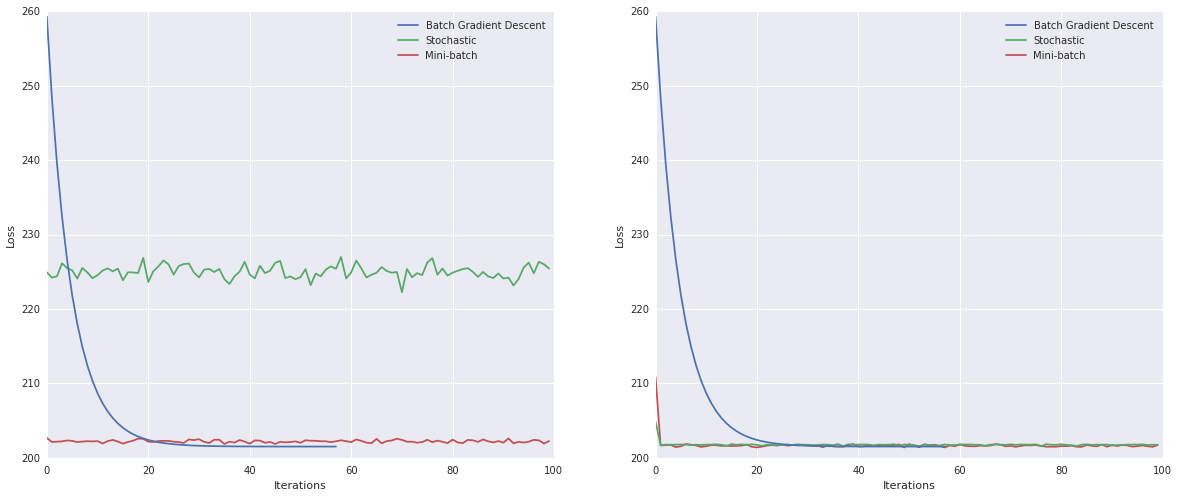

In [9]:
fig, arr = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

#left image
_, _, gd_loss_values, _ = gradient_descent(x,y,5,5,0.1,100,0.0001)
arr[0].plot(np.arange(gd_loss_values.size), gd_loss_values, label="Batch Gradient Descent", zorder=3)

_, _, sgd_loss_values, _ = stochastic_gradient_descent(x,y,5,5,0.1, 100, 0.0001)
arr[0].plot(np.arange(sgd_loss_values.size), sgd_loss_values, label="Stochastic",zorder=2)

_, _, mbsgd_loss_values, _ = mini_batch_stochastic_gradient_descent(x,y,5,5, 0.1, 100, 0.0001)
arr[0].plot(np.arange(mbsgd_loss_values.size), mbsgd_loss_values, label="Mini-batch", zorder=1)

arr[0].set_xlabel("Iterations")
arr[0].set_ylabel("Loss")
arr[0].legend()


#right image
_, _, gd_loss_values, _ = gradient_descent(x,y,5,5,0.1,100,0.0001)
arr[1].plot(np.arange(gd_loss_values.size), gd_loss_values, label="Batch Gradient Descent", zorder=3)

_, _, sgd_loss_values, _ = stochastic_gradient_descent(x,y,5,5,0.001, 100, 0.0001)
arr[1].plot(np.arange(sgd_loss_values.size), sgd_loss_values, label="Stochastic",zorder=2)

_, _, mbsgd_loss_values, _ = mini_batch_stochastic_gradient_descent(x,y,5,5, 0.01, 100, 0.0001)
arr[1].plot(np.arange(mbsgd_loss_values.size), mbsgd_loss_values, label="Mini-batch", zorder=1)

arr[1].set_xlabel("Iterations")
arr[1].set_ylabel("Loss")
arr[1].legend()


plt.show()

Finally, we have chosen to plot two images instead of one to show the different behaviour we can obtain by playing with the learning rate. In the image on the left, all the algorithm have the same learning rate (0.1); in the image on the right, the learning rate has been tuned so that each algoritmh can reach the optimal region of solutions. All the other parameters (initial thetas, marginal improvement, number of epochs ecc..) are the same in both the cases.


As said, the batch gradient descent computes the gradient using the entire dataset, that's great for convex spaces because it moves directly towards an optimum (local/global) solution. Instead, the stochastic gradient descent computes the gradient using single samples, which works well for spaces with lots of local maxima/minima, but it results in a larger variance of the loss function. However, since single samples are really noisy, mini-batches can be used to leverage a little of the noise out, reducing the amount of jerk. A good balance is struck when the minibatch size is small enough to avoid some of the local minima, but large enough that it doesn't avoid the global minima or better-performing local minima.
One benefit of two stochastic approaches is that they are computationally faster with large datasets that can't be held in memory, and, generally, they get close to the optimal solution much faster than the batch method. However, they won't fully converge to the minimum, so they are useful when we are satisfied with an approximation of the solution to our optimization problem.

By looking at the obtained graphs, in both cases, we can notice how the two stochastic versions rapidly reach their optimal/suboptimal region and then keep oscillating for 'max_iter', with never fully converging or stopping because of the marginal improvement. Instead, the batch gradient descent, slowly converges to the solution, breaking the loop much earlier (after less then 60 iterations).

In the first case, with a learning rate that is good for the batch gradient descent but that is not for the stochastic algorithm, we can see how the solution given by the latter is far from the "optimal" solution we are looking for. The mini-batch, instead, comes closer to the optimal solution despite the "high" learning rate.

For the second image, instead, we have used the learning rate values that have been tuned in the questions above (different values for each algorithm). In this case it is easy to see how, in all the three cases, the resulting found solutions come closer to the optimum respect to the ones found before. This happens because of the lower learning rate used for the stochastic algorithms, which actually slows down the "descent" to the solution. In fact, it is possible to see that more iterations are needed (for the two stochastics) to reach the optimal region, while in the first case, they reached their final space of solutions within only one iteration. Anyhow, as expect, the batch is still much slower in coming closer to the optimal solution, but it converges and break the loop finding better results then the others.

## Distributed Mini-Batch Stochastic Gradient Descent
We're now ready to study the problem of distributed, mini-batch stochastic gradient descent. Clearly, so far we've worked with very small datasets: as a consequence it is hard to appreciate the computational bottleneck of serial implementations. But before we delve into an experimental setting, and try to spice things up with larger datasets, let's focus on the problem per se.

The problem statement is as follows: we need to design a distributed version of the algorithm we examined above, that is the Mini-Batch Stochastic Gradient Descent. In the interest of time, and also because in this laboratory we want to work with Apache Spark, we will look at **synchronous** distributed algorithms. Don'y worry, things will be much more clear in the next section!

As a complement to this introduction, here's a list of references that are useful for this Notebook, and more generally that constitute the base for those of you interested in distributed optimization algorithms, an important element of large-scale machine learning.

The first reference is a research paper that was published in 2010, in a very important conference called NIPS. I suggest to have a look at section 1 only, unless you want to pursue a PhD, in which case I strongly suggest to contact me, I'm always looking for bright students to work with!

The following references are a collection of pointers to real code, which essentially implement the ideas presented in the research paper we mentioned. Beware, this is Scala code, whereas we use Python. Nevertheless, you'll find a lot of inspiring hints for your own code. Again, I suggest to start simple, and avoid the regularization part. On another note, it is interesting to look at code that is meant to be integrated as a contribution to a popular open source software, such as Apache Spark, and in particular MLLib. This is in stark contrast to the "coding style" we adopt in this Notebook, which is to be considered experimental, and far from being compliant with any principled approach to software engineering.


#### References
* Parallelized Stochastic Gradient Descent: http://martin.zinkevich.org/publications/nips2010.pdf
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/ParallelizedSGD.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/SGDUpdater.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/test/scala/org/apache/spark/mllib/optimization/ParallelizedSGDSuite.scala

### Some useful hints to design your distibuted algorithm

In this Notebook we will use Apache Spark, which is simply a fantastic tool! As we've learned in class (and this is actually true for Hadoop MapReduce as well as for any other distributed computing framework embracing the Bulk Synchrnous Parallel (BSP) programming model), Apache Spark features a synchronization barrier that really helps in dealing with distributed computations. To simplify the discussion (a much more profound treatment of the subject can be found in this nice book http://www.parallel-algorithms-book.com/), in Apache Spark workers operate synchronously, in that the result of their computation, when aggregated or distributed, is processed only when **all** workers are done. So on the one hand, this simplifies the programming model, while on the other hand, this might introduce "stragglers", that is slow workers that penalize the performance of your distributed algorithm.

So what are the basic steps you should follow to design and implement your distributed algorithm?

#### Algorithm pseudo-code
In what follows, we outline the algorithm pseudo-code, to help you think about your algorithm implementation.

```python
for i in range(iterations)
  
  # Randomly partition the input, giving T examples to each machine.
  mini_batches = sample(input_data)

  # Initialize random paramters
  params = initialize
  
  # This part executes in parallel, on each of the k worker machines
  # This is essentially the same code as for the serial implementation
  # Indeed, we're working on an embarassingly parallel formulation
  for data in mini_batch: 
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
    
  # Here we aggregate from all machines, and compute the update for iteration i
  # The update is simply the average of all updates coming from each of the k worker machines
  Aggregate from all computers params = average(params_k)
```

#### Input data and parameters
As for the input data, we want to use the same procedure we used from the beginning of the Notebook: we use scikit learn to generate our $x$ and $y$.
Then, you have to find ways to **partition** this data across the machines you have in your cluster. The method ```sc.parallelize``` comes handy here.

Once you have a parallel collection, that takes the form of an ```RDD```, you'll have to ```sample``` from it, to create random mini batches, each of which will be used **independently** by each worker machine to process its own data. Be careful that here we want to **keep the data partitioning** of our original data. You should be wise enough to lookup for the PySpark API to get the details of the methods we suggested here: ```sample``` and ```mapPartitions```.

Last but not least, we have to take care about the parameters! The initial parameter values, as well as any updates to them, must be shipped to all worker machines. There are various ways to do this, exploiting the great flexibility of Apache Spark. This data could be serialized and shipped along with the code each task should execute. However, a much more efficient method to do this is to exploit what we have learned in class, namely ```broadcast variables```. You might argue that for our simple Notebook, since the parameter vector is of size 2, this is not a big deal. However, for different scenarios, like big models, having an efficient primitive to ship a lot of data to workers is a big plus: remember that broadcast variables are sent to workers using a protocol very similar to BitTorrent, a famous peer-to-peer content distribution system.

#### Driver vs. workers

Now, to clarify even further what we expect from our Apache Spark program, here's some additional information about the roles of each component invovled in the execution of the pseudo-code outlined above.


Essentially, the ```driver``` machine (the one where the ```SparkContext``` is created), is the one responsible for executing the "serial" part of the algorithm: prepare and dispatch data, and wait for the contributions coming from all machines.


Instead, the ```worker``` machines receive their task to execute, proceed independently (some faster than others), and send their updates to the driver. The driver will **wait for all updates from workers** before proceeding with the final aggregation.

#### Additional hints

As you might have heard in class, Apache Spark has a lot of surprises. On of such cool methods allow you to define the way data is aggregated. Indeed, you surely realized that (in the old Hadoop MapReduce jargon) we're talking about a "map only job": workers "map" on their minibatch, computing partial gradient updates, then send everything (more or less at the same time) to the driver machine. At the scale of this Notebook, this is rather harmless. Instead, at larger scale, this could create "congestion" in the driver: a nice solution to this would be to have the possibility to aggregate data along a tree-structure, which would involve worker machines as well as the driver.


One final note. In case you wonder how to produce an ```iterable``` in python with a singleton in it, just ```return (variable, )```.

<div class="alert alert-block alert-info">
<strong>Question 8.</strong> Implement your own version of Mini-Batch, Stochastic Gradient Descent, as a **distributed** algorithm.

    
The output of your cell should contain the following information:
<ul>
<li> The values of the paramters obtained through Gradient Descent optimization </li>
<li> The values of the paramters obtained with the above cell, using scikitlearn </li>
<li> A plot of the loss versus iterations </li>
<li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

Scikitlearn values:
Intercept:  -0.106823564161
Slope:  14.5151694796

Distributed mini-batch stochastic gradient descent values:
Intercept:  -0.0239896691801
Slope:  14.482946074


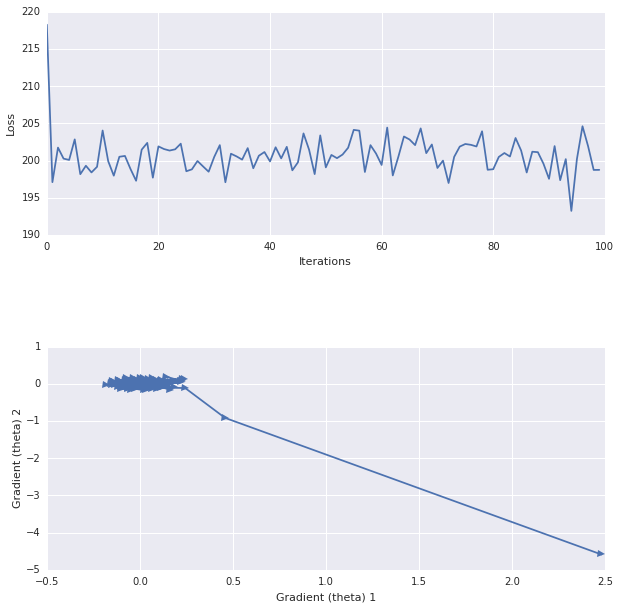

In [3]:

def distributed_mini_batch_stochastic_gradient_descent(x, y, theta1, theta2, learning_rate, max_iter, marg_improv):    
    theta1_b = sc.broadcast(theta1)
    theta2_b = sc.broadcast(theta2)
    learning_rate_b = sc.broadcast(learning_rate)
    
    ## STOCHASTIC GRADIENT DESCENT ##
    def iterable_stochastic_gradient_descent(xy):
        count = 0
        j = 0

        theta = np.array([theta1_b.value, theta2_b.value])
        gs=0
        for sample_x, sample_y in xy:
            #loss
            j += 0.5*(theta[0] + theta[1]*sample_x - sample_y)**2
            
            g0=theta[0] + theta[1]*sample_x - sample_y
            g1=(theta[0]  + theta[1] *sample_x - sample_y)*sample_x
            g=np.array([g0, g1])
            gs += g
            
            theta = theta - learning_rate_b.value*g
            count += 1
        
        return ([theta, j/count, gs/count, 1], )
    
    ## BATCH GRADIENT DESCENT ##
    def iterable_batch_gradient_descent(xy):
        x,y = zip(*xy)
        x = np.array(x)
        y = np.array(y)
        
        #theta array
        theta = np.array([theta1_b.value, theta2_b.value])
        #x matrix with 1s
        x_ones = np.array([np.ones(x.size),x])

        #loss (j) gradient (g)
        x_theta = x_ones.T.dot(theta)
        j = 0.5 * (x_theta - y).dot((x_theta - y).T) / x.size
        g = x_ones.dot(x_theta - y) / x.size
        theta = theta - learning_rate_b.value*g
        
        return ([theta, j, g, 1], )
        
    
    xy = np.array(list(zip(x,y)))
    
    p_data = sc.parallelize(xy, 4)
    
    #history vectors
    loss_values=[]
    gradients=[]
    thetas=[]
    
    import sys
    bestj = sys.maxsize
    for i in range(max_iter):
        res = ( p_data.sample(False, 0.7, 42+i)
               .mapPartitions(iterable_stochastic_gradient_descent)
               .reduce(lambda res1, res2: [
                           res1[0]+res2[0], res1[1]+res2[1], res1[2]+res2[2], res1[3]+res2[3]
                        ]
                      )
              )
        theta = res[0]/res[3]
        loss = res[1]/res[3]
        gradient = res[2]/res[3]
        
        loss_values.append(loss)
        gradients.append(gradient)
        thetas.append(theta)
        
        theta1_b = sc.broadcast(theta[0])
        theta2_b = sc.broadcast(theta[1])
        
        if(loss < bestj):
            if(abs(loss-bestj) < marg_improv):
                break
            bestj = loss
    return theta, np.array(thetas), np.array(loss_values), np.array(gradients)

#########################################
#########################################

dmbsgd_theta, dmbsgd_thetas, dmbsgd_loss_values, dmbsgd_gradients = distributed_mini_batch_stochastic_gradient_descent(x,y,5,5, 0.001, 100, 0.0001)

print("Scikitlearn values:")
print("Intercept: ", intercept)
print("Slope: ", slope)
print("\nDistributed mini-batch stochastic gradient descent values:")
print("Intercept: ", dmbsgd_theta[0])
print("Slope: ", dmbsgd_theta[1])

fig, arr = plt.subplots(2)
fig.subplots_adjust(hspace=.5)
fig.set_size_inches(10, 10)

arr[0].plot(np.arange(dmbsgd_loss_values.size), dmbsgd_loss_values)
arr[0].set_xlabel("Iterations")
arr[0].set_ylabel("Loss")
arr[1].plot(dmbsgd_gradients[:,0], dmbsgd_gradients[:,1], '->')
arr[1].set_xlabel("Gradient (theta) 1")
arr[1].set_ylabel("Gradient (theta) 2")

plt.show()

We decided to use the "Stochastic Gradient Descent" as algorithm executed by the workers (NB: also the batch gradient descent has been reimplemented in the distributed case for experimental reasons). The sample function is used with a franction of 0.7 of the initial dataset size, without replacement. This means that we consider the 70% of the initial dataset as rapresentative of the entire set. This is particularly recommended in case of very large datasets. Despite this is not the case, we decided to proceed in this way to implement a scalable algorithm which behaves in a well manner also in the case of big datasets. Obviously the output is estimated on a "different" dataset (actually a subset of it), and this can alterate also the final solution.

The obtained output, as expected, follow the "output pattern" of the stochastic gradient descent, with "big steps" towards the optimal region as we can see from the gradient path graph. However, in this case the oscillation is caused by the sampling.
The algorithm never stops until the number of epochs is reached because of the low marginal increment condition.

<div class="alert alert-block alert-info">
<strong>Question 9.</strong> Inspecting your input data, and its partitioning.
<br>

Answer the following questions:
<ul>
    <li>What is the best way to partition your data, given your cluster configuration? How many partitions did you chose</li>
    <li>Given the number of partitions from the first point, how many RDD blocks is your data broken into?</li>
    <li>What would be different if you were to concieve the same algorithm digesting input data stored as a CSV file on HDFS? Argue about how to "ship" data to worker machines, partitions, blocks, etc...</li>
</ul>
</div>


**```[HINT]```** The questions above are best answered by looking at the Spark Master Web UI.

- Since the cluster is composed by 4 nodes (workers) of 1 core and 8GB RAM each, we have chosen to use 4 partitions to better take advantage of the actual configuration. This is true in this particular case, in which the datasets used in the various tests are relatively small; however, in case of really big datasets it could not perform well because of the big "batches" each worker may have to work with. So in that case it could be better to use more partitions (preferably multiples of the cluster size to distribute evenly) to implement a "mini-batch like" mechanism.
- The number of RDD blocks is 4, since we split the data in 4 partitions
- The main difference would be that the dataset should not "be parallelized" anymore (currently we call the "parallelize" function which copies the elements of the collection to form a distributed dataset - RDD - that can be operated on in parallel) because PySpark can create distributed datasets from any storage source (supported by Hadoop in case of HDFS). In case the dataset would be stored in a CSV on HDFS, it could be partitioned in different blocks, stored on different machines. With HDFS the Spark driver contacts NameNode about the DataNodes (ideally local) containing the various blocks of a file or directory as well as their locations, and then schedules the work to the SparkWorkers: it tries to execute tasks as close to the data as possible to minimize data transfer (over the wire).

<div class="alert alert-block alert-info">
<strong>Question 10.</strong> Finding bottlenecks.

<ul>
    <li>What is the bottleneck in the current implementation of your algorithm?</li>
    <li>Can you nail down exactly which method is causing this bottleneck?</li>
    <li>Can you suggest ways to mitigate or eliminate the bottleneck?</li>
</ul>
</div>

- The bottleneck in the current implementation is caused by the 1 to N relation which exists between the driver (1) and the workers (N): the driver has to broadcast the thetas variables at each iteration (1 to N) and then wait all the workers to complete their tasks to finally collect all the data (N to 1). In the case of reduce/aggregate functions, in fact, in Spark all the partitions have to send their reduced value to the driver machine, and that machine spends linear time on the number of partitions due to the CPU cost in merging partial results and the network bandwidth limit. It becomes a bottleneck when there are many partitions and the data from each partition is big.
- The method that is causing the bottleneck is the "reduce"
- We can use an aggregation communication pattern based on multi-level aggregation trees by using the treeReduce/treAggregate functions; in this case, the data are combined partially on a small set of executors before they are sent to the driver, which dramatically reduces the load the driver has to deal with. In this way there is no single bottleneck machine.

<div class="alert alert-block alert-info">
<strong>Question 11.</strong> Comparison of serial vs. distributed algorithms.
</div>

Given all the implementation effort you did so far, this question is about an experimental study on scalability. Given input data sizes in the range $[10^2, 10^3, 10^4, 10^5]$, collect the run-time and the loss rate at convergence for all variants of the serial algorithms and for the distributed one. Produce a plot with 2 y-axis, one for the run-time, one for the loss rate, and one x-axis with the input data size.

Discuss your results.


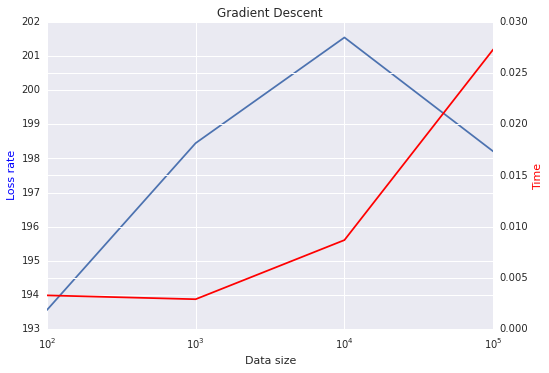

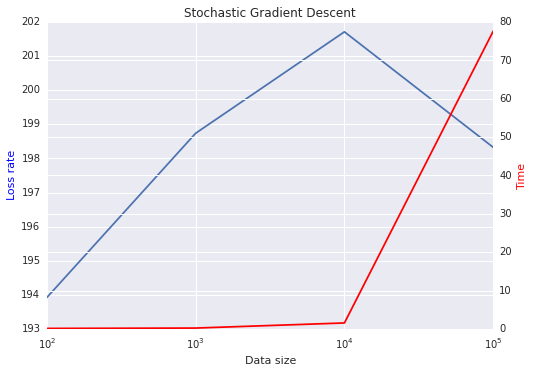

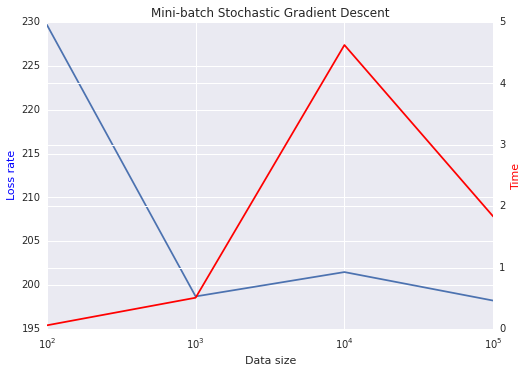

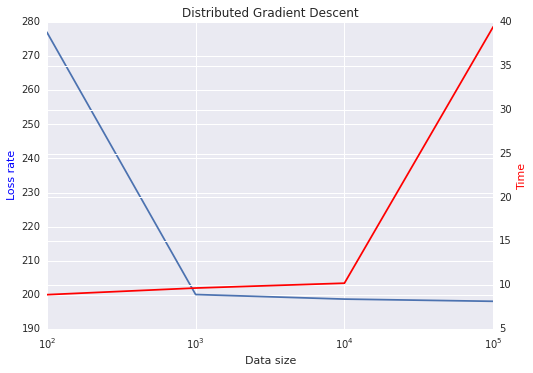

In [32]:
import time

def f(data_size, f_code):
    x, y = make_regression(n_samples = data_size, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
    x = x.flatten()
    
    if(f_code == "Gradient Descent"):
        before = time.time()
        _, _, loss, _ = gradient_descent(x,y,5,5,0.1,100,0.01)
        after = time.time()
        t = after-before
    elif(f_code == "Stochastic Gradient Descent"):
        before = time.time()
        _, _, loss, _ = stochastic_gradient_descent(x,y,5,5,0.001, 100, 0.01)
        after = time.time()
        t = after-before
    elif(f_code == "Mini-batch Stochastic Gradient Descent"):
        before = time.time()
        _, _, loss, _ = mini_batch_stochastic_gradient_descent(x,y,5,5, 0.01, 100, 0.01)
        after = time.time()
        t = after-before
    elif(f_code == "Distributed Gradient Descent"):
        before = time.time()
        _, _, loss, _ = distributed_mini_batch_stochastic_gradient_descent(x,y,5,5, 0.001, 100, 0.01)
        after = time.time()
        t = after-before
    else:
        print('undefined function')
        return None
    
    return t, loss[-1]


def plot_f(f_code):
    t=[]
    loss=[]
    data_sizes = [100,1000,10000,100000]
    for i in data_sizes:
        t_f, loss_f = f(i, f_code)
        t.append(t_f)
        loss.append(loss_f)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(f_code)
    ax.plot(data_sizes, loss)
    ax.set_xlabel("Data size")
    ax.set_ylabel("Loss rate", color='b')
    ax.set_xscale("log")
    ax2 = ax.twinx()
    ax2.plot(data_sizes, t, 'r')
    ax2.set_xlabel("Data size")
    ax2.set_ylabel("Time", color='r')
    plt.show()
    

plot_f("Gradient Descent")
plot_f("Stochastic Gradient Descent")
plot_f("Mini-batch Stochastic Gradient Descent")
plot_f("Distributed Gradient Descent")

NB: we decided to use one grid per algorithm plot because of clarity reasons; it got very messy with all plots in the same grid.

In the four represented images, we can see the loss rate and the execution time curves respectively represented in blue and in red.
The parameters used for the executions are the same as in all the experiments conducted before: 5 and 5 as initial thetas, 100 epochs and different learning rates based on the algorithm type (0.1 for the batch, 0.01 for the mini-batch, 0.001 for the stochastic). As already said, the learning rate has been intentionally decreased in the stochastic algorithms to slow down the "descent" in order to stuck the final oscillation in a restricted region closer to the optimal solution. Also in the case of the distributed version it has been used a low learning rate because it implements a stochastic algorithm. However, the marginal improvement has been increased of a factor of 10 respect to our previous experiments to speed up the execution of the stochastics, in particular for the bigger dataset.
For the mini-batch stochastic gradient descent the batch size is set to 32.

Generally, we can see that the execution time increases exponentially as the size of the considered dataset increases. This is an obvious consequence of the fact that operating on more data require additional computational time then operating on less data. In this context, we can see that some of the algorithms takes long time to execute if compared to the batch version; that's because, in most cases, and in particular for the stochastics, all the iterations are performed without breaking the loop for the marginal increment condition (as we have already said, the stochastics keep spinning around the reached region of solutions. However, there are cases in which the time decreases also if the size of the datasets increases - for example that's the case of the mini batch between 10^4 and 10^5 - and this can happen if the stopping condition on the marginal increment is verified; we have prooved that running the algorithms with a more "restricting" marginal increment condition (for example with marginal increment = 0) obviously avoids this behaviour and the time always increases as the size increases.
Another thing to be noticed is the fact that the distributed descent, despite implements a stochastic algorithm for the workers, on average takes more time then the stochastic, in particular in the case of small datasets. This can be explained by the additional overhead that the distributed version has to manage respect to the stochastic.

About the loss rate we can see that all the algorithms perform well in most of the cases. The results obtained with the "batch", as expected, are the best among the different versions of gradient descent; the stochastic obtains results that are quite close to the batch ones; also the mini-batch shows good performances except for the case of the little dataset. A separate discourse needs to be entered for the distributed gradient descent: apparently the results obtained in the case of 10^4 seems to be better then the ones obtained with the batch version; however we don't have to forget that we are using the sample function on a fraction of 0.7 of the dataset, which introduce a sampling error: "in statistics, sampling error is incurred when the statistical characteristics of a population are estimated from a subset, or sample, of that population. Since the sample does not include all members of the population, statistics on the sample generally differ from the characteristics of the entire population.". This obviosly doesn't work well for small datasets, but it solves all the scalability issues.